In [1]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import MultipleLocator
from matplotlib import pyplot as plt
from FetusGrowth_BWPrediction import *
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
import seaborn as sns

In [2]:
data = pd.read_csv('seethapathyCleanedData.csv')
data = getMeasurements_int(data)
data = data.drop([i for i in range(len(data['GA'])) if list(data['GA'])[i][1] > 24]).reset_index(drop = True)
data = data.drop([i for i in range(len(data['GA'])) if list(data['GA'])[i][-1] < 27]).reset_index(drop = True)
ml_data = rmMultipleUS(data)
X = ml_data[['GA_AT_DELIVERY','GA','BPD', 'HC', 'AC','FL_Rt']]
y = ml_data['BIRTH_WEIGHT']

In [3]:
df_obj = pd.read_pickle(r'BWPridiction_LR.pickle')

In [4]:
actual_bw = [df_obj['BWActual'][i][0] for i in range(len(df_obj))]
bw_pred_lr_35week = [df_obj['BWPredicted35'][i][0] for i in 
                        range(len(df_obj))]
bw_pred_lr_24week = [df_obj['BWPredicted24'][i][0] for i in 
                        range(len(df_obj))]


In [5]:
df_plot = pd.read_csv('predictedVal.csv')
X_pred_24week = df_plot[['HC24_atDel','AC24_atDel','BPD24_atDel','FL24_atDel','A_HC24_atDel',
                       'A_AC24_atDel','A_BPD24_atDel','A_FL24_atDel']]
X_pred_35week = df_plot[['HC35_atDel','AC35_atDel','BPD35_atDel','FL35_atDel',
                         'A_HC35_atDel','A_AC35_atDel','A_BPD35_atDel','A_FL35_atDel']]

In [6]:
bw_pred_ig_35week = IGbirthWeightPred(X_pred_35week['HC35_atDel'],X_pred_35week['AC35_atDel'])
bw_pred_hd_35week = Hadlock2birthWeightPred(X_pred_35week['AC35_atDel'],
                                           X_pred_35week['BPD35_atDel'],X_pred_35week['FL35_atDel'])
bw_pred_shd_35week = ShepardbirthWeightPred(X_pred_35week['AC35_atDel'],X_pred_35week['BPD35_atDel'])




bw_pred_ig_24week = IGbirthWeightPred(X_pred_24week['HC24_atDel'],X_pred_24week['AC24_atDel'])
bw_pred_hd_24week = Hadlock2birthWeightPred(X_pred_24week['AC24_atDel'],
                                           X_pred_24week['BPD24_atDel'],X_pred_24week['FL24_atDel'])
bw_pred_shd_24week = ShepardbirthWeightPred(X_pred_24week['AC24_atDel'],X_pred_24week['BPD24_atDel'])

In [7]:
gadel = list(X['GA_AT_DELIVERY'])

hcIg,acIg, bpdIg, flIg = [],[],[],[]
for i in range(len(ml_data)):
    hcIg.append(hc_mean_sd(gadel[i])[0])
    acIg.append(ac_mean_sd(gadel[i])[0])
    bpdIg.append(bpd_mean_sd(gadel[i])[0])
    flIg.append(fl_mean_sd(gadel[i])[0])

In [8]:
bw_pred_ig_IG = IGbirthWeightPred(hcIg,acIg)
bw_pred_ig_HD = Hadlock2birthWeightPred(acIg,bpdIg,flIg)
bw_pred_ig_SHD = ShepardbirthWeightPred(acIg,bpdIg)

In [9]:
new_data = pd.read_csv('validationCohort.csv')
data = getMeasurements_int(new_data)
new_ml_data = rmMultipleUS(data)
new_ml_data.drop(new_ml_data.loc[new_ml_data['BIRTH_WEIGHT']==0].index, inplace=True)
new_ml_data = new_ml_data.dropna().reset_index(drop = True)
X_new = new_ml_data.drop(['BIRTH_WEIGHT','PATIENT_ID','AGE'], axis=1)
y_new = new_ml_data['BIRTH_WEIGHT']

In [10]:
t0C_list = pd.read_csv('t0_c.csv')

t0_hc,c_hc = t0C_list['t0_hc'][0], t0C_list['c_hc'][0]
t0_ac,c_ac = t0C_list['t0_ac'][0], t0C_list['c_ac'][0]
t0_bpd,c_bpd = t0C_list['t0_bpd'][0], t0C_list['c_bpd'][0]
t0_fl,c_fl = t0C_list['t0_fl'][0], t0C_list['c_fl'][0]

index_ga24 = [get_count_GALessThan24(x) for x in X_new['GA']]
index_ga35 = [get_count_GALessThan35(x) for x in X_new['GA']]
gaDel = list(X_new['GA_AT_DELIVERY'])

X_new_df24 = CalA_predBiometries(X_new,t0_hc, c_hc, t0_ac, c_ac, t0_bpd,c_bpd, t0_fl, c_fl,index_ga24, gaDel)

X_new_df35 = CalA_predBiometries(X_new,t0_hc, c_hc, t0_ac, c_ac, t0_bpd,c_bpd, t0_fl, c_fl,index_ga35, gaDel)


In [11]:
param_name = [df_obj['Parameter_coeff'][0][i][1] 
                     for i in range(len(df_obj['Parameter_coeff'][0]))]

param_val_list = []
for j in range (len(df_obj)):
    param_val_list.append([df_obj['Parameter_coeff'][j][i][0] 
                                  for i in range(len(df_obj['Parameter_coeff'][0]))])
    
    
df_param = pd.DataFrame(param_val_list, columns = param_name)
parameter_coeff = df_param.mean(axis = 0)

In [12]:
X_new_df24 = X_new_df24[list(parameter_coeff.index)]
X_new_df35 = X_new_df35[list(parameter_coeff.index)]
intercept = df_obj['intercept'].mean()

In [13]:
y_pred24_new = (parameter_coeff*X_new_df24).sum(axis = 1)+intercept
y_pred35_new = (parameter_coeff*X_new_df35).sum(axis = 1)+intercept

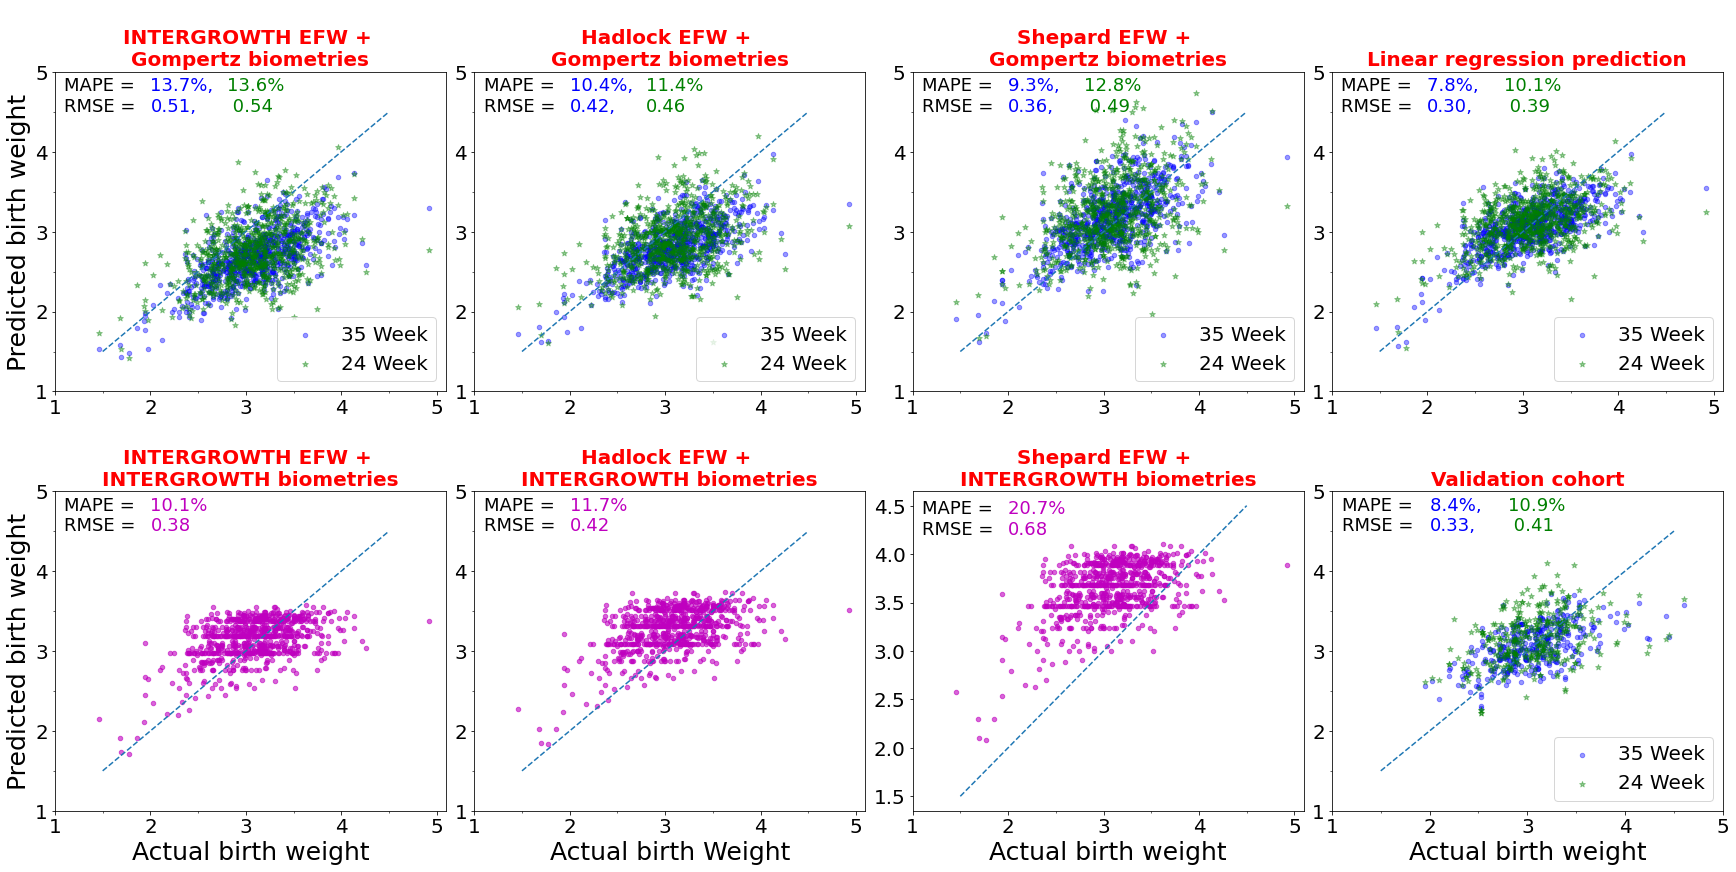

In [32]:
fig, ax = plt.subplots(2,4, figsize=(24, 12), constrained_layout=True)

plt.rcParams.update({
"xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'legend.fontsize': 20,
    'axes.labelsize': 25 ,
    
     'axes.titlesize': 20,
   
    'font.serif': 'DejaVu Serif'
    })



ax[0,0].scatter(actual_bw, bw_pred_ig_35week,s=20,color='b',alpha = 0.4,label = '35 Week')
ax[0,0].scatter(actual_bw, bw_pred_ig_24week,color='g',marker='*',alpha = 0.4,label = '24 Week')
ax[0,0].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[0,1].scatter(actual_bw, bw_pred_hd_35week,s=20,color='b',alpha = 0.4,label = '35 Week')
ax[0,1].scatter(actual_bw, bw_pred_hd_24week,color='g',marker='*',alpha = 0.4,label = '24 Week')
ax[0,1].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[0,2].scatter(actual_bw, bw_pred_shd_35week,s=20,color='b',alpha = 0.4,label = '35 Week')
ax[0,2].scatter(actual_bw, bw_pred_shd_24week,color='g',marker='*',alpha = 0.4,label = '24 Week')
ax[0,2].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[0,3].scatter(actual_bw, bw_pred_lr_35week,s=20,color='b',alpha = 0.4,label = '35 Week')
ax[0,3].scatter(actual_bw, bw_pred_lr_24week,color='g',marker='*',alpha = 0.4,label = '24 Week')
ax[0,3].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[1,0].scatter(actual_bw, bw_pred_ig_IG,s=20,color='m',alpha = 0.6)
ax[1,0].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[1,1].scatter(actual_bw, bw_pred_ig_HD,s=20,color='m',alpha = 0.6)
ax[1,1].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[1,2].scatter(actual_bw, bw_pred_ig_SHD,s=20,color='m',alpha = 0.6)
ax[1,2].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[1,3].scatter(y_new, y_pred35_new,s=20,color='b',alpha = 0.4,label = '35 Week')
ax[1,3].scatter(y_new, y_pred24_new,color='g',marker='*',alpha = 0.4,label = '24 Week')
ax[1,3].plot([1.5, 4.5], [1.5, 4.5],'--')



ax[0,0].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

ax[0,0].text(2,4.5,'{:0.1f}%,  \n{:0.2f},'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_ig_35week)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_ig_35week))),
             c = 'b',fontsize = 18)


ax[0,0].text(2.8,4.5, '{:0.1f}% \n {:0.2f}'.
            format(mean_absolute_percentage_error(actual_bw, bw_pred_ig_24week)*100,
                   np.sqrt(mean_squared_error(actual_bw, bw_pred_ig_24week))),c = 'g',
             fontsize = 18)


ax[0,1].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)
ax[0,1].text(2,4.5,'{:0.1f}%,  \n{:0.2f},'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_hd_35week)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_hd_35week))),
             c = 'b',fontsize = 18)

ax[0,1].text(2.8,4.5, '{:0.1f}%  \n{:0.2f}'.
            format(mean_absolute_percentage_error(actual_bw, bw_pred_hd_24week)*100,
                  np.sqrt(mean_squared_error(actual_bw, bw_pred_hd_24week))),c = 'g',
             fontsize = 18)


ax[0,2].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

ax[0,2].text(2,4.5,'{:0.1f}%,  \n{:0.2f},'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_shd_35week)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_shd_35week))),
             c = 'b',fontsize = 18)


ax[0,2].text(2.8,4.5, '{:0.1f}% \n {:0.2f}'.
            format(mean_absolute_percentage_error(actual_bw, bw_pred_shd_24week)*100,
                   np.sqrt(mean_squared_error(actual_bw, bw_pred_shd_24week))),c = 'g',
             fontsize = 18)

ax[0,3].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

ax[0,3].text(2,4.5,'{:0.1f}%,  \n{:0.2f},'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_lr_35week)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_lr_35week))),
             c = 'b',fontsize = 18)


ax[0,3].text(2.8,4.5, '{:0.1f}% \n {:0.2f}'.
            format(mean_absolute_percentage_error(actual_bw, bw_pred_lr_24week)*100,
                   np.sqrt(mean_squared_error(actual_bw, bw_pred_lr_24week))),c = 'g',
             fontsize = 18)


ax[1,0].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

ax[1,0].text(2,4.5,'{:0.1f}%  \n{:0.2f}'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_ig_IG)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_ig_IG))),
             c = 'm',fontsize = 18)


ax[1,1].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

ax[1,1].text(2,4.5,'{:0.1f}%  \n{:0.2f}'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_ig_HD)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_ig_HD))),
             c = 'm',fontsize = 18)



ax[1,2].text(1.1,4.2,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)
ax[1,2].text(2,4.2,'{:0.1f}%  \n{:0.2f}'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_ig_SHD)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_ig_SHD))),
             c = 'm',fontsize = 18)



ax[1,3].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

ax[1,3].text(2,4.5,'{:0.1f}%,  \n{:0.2f},'.
             format(mean_absolute_percentage_error(y_new, y_pred35_new)*100,
                    np.sqrt(mean_squared_error(y_new, y_pred35_new))),
             c = 'b',fontsize = 18)


ax[1,3].text(2.8,4.5, '{:0.1f}% \n {:0.2f}'.
            format(mean_absolute_percentage_error(y_new, y_pred24_new)*100,
                   np.sqrt(mean_squared_error(y_new, y_pred24_new))),c = 'g',
             fontsize = 18)


ax[0,0].set_xticks(np.arange(1, 6, 1))
ax[0,0].set_yticks(np.arange(1, 6, 1))

ax[0,1].set_xticks(np.arange(1, 6, 1))
ax[0,1].set_yticks(np.arange(1, 6, 1))

ax[0,2].set_xticks(np.arange(1, 6, 1))
ax[0,2].set_yticks(np.arange(1, 6, 1))

ax[0,3].set_xticks(np.arange(1, 6, 1))
ax[0,3].set_yticks(np.arange(1, 6, 1))

ax[1,0].set_xticks(np.arange(1, 6, 1))
ax[1,0].set_yticks(np.arange(1, 6, 1))

ax[1,1].set_xticks(np.arange(1, 6, 1))
ax[1,1].set_yticks(np.arange(1, 6, 1))

ax[1,2].set_xticks(np.arange(1, 6, 1))
ax[1,3].set_yticks(np.arange(1, 6, 1))

ax[1,3].set_xticks(np.arange(1, 6, 1))
ax[1,3].set_yticks(np.arange(1, 6, 1))

ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0,2].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[0,3].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0,3].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[1,2].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1,2].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[1,3].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1,3].yaxis.set_minor_locator(MultipleLocator(0.5))

#ax[0,0].set_xlabel('Actual birth weight')
ax[0,0].set_ylabel('Predicted birth weight')

#ax[0,1].set_ylabel('Predicted Birth weight')
#ax[0,1].set_xlabel('Actual birth Weight')

#ax[0,2].set_ylabel('Predicted birth weight')
#ax[0,2].set_xlabel('Actual birth weight')

#ax[0,3].set_ylabel('Predicted Birth weight')
#ax[0,3].set_xlabel('Actual birth weight')

ax[1,0].set_xlabel('Actual birth weight')
ax[1,0].set_ylabel('Predicted birth weight')

#ax[1,1].set_ylabel('Predicted Birth weight')
ax[1,1].set_xlabel('Actual birth Weight')

#ax[1,2].set_ylabel('Predicted birth weight')
ax[1,2].set_xlabel('Actual birth weight')

#ax[1,3].set_ylabel('Predicted Birth weight')
ax[1,3].set_xlabel('Actual birth weight')


ax[0,0].set_title('INTERGROWTH EFW + \nGompertz biometries',color = 'r',weight='bold')
ax[0,1].set_title('\nHadlock EFW + \nGompertz biometries',color = 'r',weight='bold')
ax[0,2].set_title('\nShepard EFW + \nGompertz biometries',color = 'r',weight='bold')
ax[0,3].set_title('Linear regression prediction',color = 'r',weight='bold')

ax[1,0].set_title('INTERGROWTH EFW + \nINTERGROWTH biometries',color = 'r',weight='bold')
ax[1,1].set_title('\nHadlock EFW + \nINTERGROWTH biometries',color = 'r',weight='bold')
ax[1,2].set_title('\nShepard EFW + \nINTERGROWTH biometries',color = 'r',weight='bold')
ax[1,3].set_title('Validation cohort',color = 'r',weight='bold')

ax[0,0].legend(loc = 'lower right', frameon = True);
ax[0,1].legend(loc = 'lower right', frameon = True);
ax[0,2].legend(loc = 'lower right', frameon = True);
ax[0,3].legend(loc = 'lower right', frameon = True);
#ax[1,0].legend(loc = 'lower right', frameon = True);
#ax[1,1].legend(loc = 'lower right', frameon = True);
#ax[1,2].legend(loc = 'lower right', frameon = True);
ax[1,3].legend(loc = 'lower right', frameon = True);

plt.savefig('FigOutput/BWPridiction_plot.png',dpi = 600,bbox_inches='tight')
plt.savefig('FigOutput/BWPridiction_plot.pdf',dpi = 600,bbox_inches='tight')

# Final Biometries plot

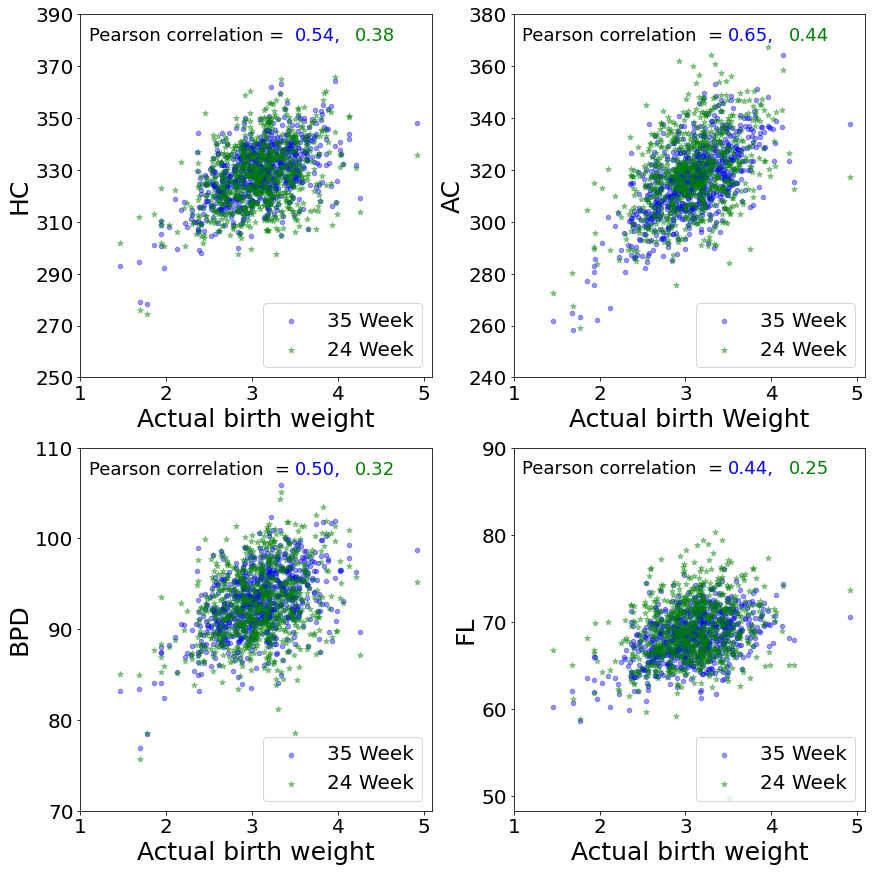

In [15]:
fig, ax = plt.subplots(2,2, figsize=(12, 12), constrained_layout=True)

plt.rcParams.update({
"xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'legend.fontsize': 20,
    'axes.labelsize': 25 ,
    
     'axes.titlesize': 20,
   
    'font.serif': 'DejaVu Serif'
    })

ax[0,0].scatter(actual_bw, df_plot['HC35_atDel'],s=20,color='b',alpha = 0.4,label = '35 Week')
ax[0,0].scatter(actual_bw, df_plot['HC24_atDel'],color='g',marker='*',alpha = 0.4,label = '24 Week')
#ax[0,0].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[0,1].scatter(actual_bw, df_plot['AC35_atDel'],s=20,color='b',alpha = 0.4,label = '35 Week')
ax[0,1].scatter(actual_bw, df_plot['AC24_atDel'],color='g',marker='*',alpha = 0.4,label = '24 Week')
#ax[0,1].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[1,0].scatter(actual_bw, df_plot['BPD35_atDel'],s=20,color='b',alpha = 0.4,label = '35 Week')
ax[1,0].scatter(actual_bw, df_plot['BPD24_atDel'],color='g',marker='*',alpha = 0.4,label = '24 Week')
#ax[1,0].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[1,1].scatter(actual_bw, df_plot['FL35_atDel'],s=20,color='b',alpha = 0.4,label = '35 Week')
ax[1,1].scatter(actual_bw, df_plot['FL24_atDel'],color='g',marker='*',alpha = 0.4,label = '24 Week')
#ax[1,1].plot([1.5, 4.5], [1.5, 4.5],'--')


ax[0,0].text(1.1,380,'Pearson correlation =',c = 'k',fontsize = 18)

ax[0,0].text(3.5,380,'{:0.2f},'.
             format(pearsonr(actual_bw, df_plot['HC35_atDel'])[0]),
             c = 'b',fontsize = 18)

ax[0,0].text(4.2,380, '{:0.2f}'.
            format(pearsonr(actual_bw, df_plot['HC24_atDel'])[0]),c = 'g',
             fontsize = 18)




ax[0,1].text(1.1,370,'Pearson correlation  =',c = 'k',fontsize = 18)

ax[0,1].text(3.5,370,'{:0.2f},'.
             format(pearsonr(actual_bw, df_plot['AC35_atDel'])[0]),
             c = 'b',fontsize = 18)

ax[0,1].text(4.2,370, '{:0.2f}'.
            format(pearsonr(actual_bw, df_plot['AC24_atDel'])[0]),c = 'g',
             fontsize = 18)




ax[1,0].text(1.1,107,'Pearson correlation  =',c = 'k',fontsize = 18)
ax[1,0].text(3.5,107,'{:0.2f},'.
             format(pearsonr(actual_bw, df_plot['BPD35_atDel'])[0]),
             c = 'b',fontsize = 18)

ax[1,0].text(4.2,107, '{:0.2f}'.
            format(pearsonr(actual_bw, df_plot['BPD24_atDel'])[0]),c = 'g',
             fontsize = 18)





ax[1,1].text(1.1,87,'Pearson correlation  =',c = 'k',fontsize = 18)
ax[1,1].text(3.5,87,'{:0.2f},'.
             format(pearsonr(actual_bw, df_plot['FL35_atDel'])[0]),
             c = 'b',fontsize = 18)

ax[1,1].text(4.2,87, '{:0.2f}'.
            format(pearsonr(actual_bw, df_plot['FL24_atDel'])[0]),c = 'g',
             fontsize = 18)


ax[0,0].set_xticks(np.arange(1, 6, 1))
ax[0,0].set_yticks(np.arange(250, 391, 20))

ax[0,1].set_xticks(np.arange(1, 6, 1))
ax[0,1].set_yticks(np.arange(240, 400, 20))

ax[1,0].set_xticks(np.arange(1, 6, 1))
ax[1,0].set_yticks(np.arange(70, 111, 10))

ax[1,1].set_xticks(np.arange(1, 6, 1))
ax[1,1].set_yticks(np.arange(50, 91, 10))

#ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.5))
#ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.5))

#ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.5))
#ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.5))

#ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.5))
#ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.5))

#ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.5))
#ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[0,0].set_xlabel('Actual birth weight')
ax[0,0].set_ylabel('HC')

ax[0,1].set_ylabel('AC')
ax[0,1].set_xlabel('Actual birth Weight')

ax[1,0].set_ylabel('BPD')
ax[1,0].set_xlabel('Actual birth weight')

ax[1,1].set_ylabel('FL')
ax[1,1].set_xlabel('Actual birth weight')

#ax[0,0].set_title('LASSO prediction',color = 'r',weight='bold')
#ax[0,1].set_title('Intergrowth EFW',color = 'r',weight='bold')
#ax[1,0].set_title('\nShepard EFW',color = 'r',weight='bold')
#ax[1,1].set_title('\nHadlock EFW',color = 'r',weight='bold')

ax[0,0].legend(loc = 'lower right', frameon = True);
ax[0,1].legend(loc = 'lower right', frameon = True);
ax[1,0].legend(loc = 'lower right', frameon = True);
ax[1,1].legend(loc = 'lower right', frameon = True);

plt.savefig('FigOutput/BWPridiction_plot_finalBiometries.png',dpi = 600,bbox_inches='tight')
plt.savefig('FigOutput/BWPridiction_plot_finalBiometries.pdf',dpi = 600,bbox_inches='tight')

In [16]:
def calPercentage(actual_bw, pred_bw, percent):
    percent_bwPlus, percent_bwMinus = [],[]
    for bw in actual_bw:
        percent_bwPlus.append(bw+((percent/100)*bw))
        percent_bwMinus.append(bw-((percent/100)*bw))
    count = 0
    
    for i in range(len(pred_bw)):
        if pred_bw[i]< percent_bwPlus[i] and pred_bw[i]> percent_bwMinus[i]:
            count = count+1
    return np.round((count/len(actual_bw))*100,2)


In [17]:
bwpercentage = list(zip(
                        [calPercentage(actual_bw, bw_pred_lr_35week, i) for i in range(5,16,1)],
                        [calPercentage(actual_bw, bw_pred_lr_24week, i) for i in range(5,16,1)],
                        [calPercentage(actual_bw, bw_pred_ig_35week, i) for i in range(5,16,1)],
                        [calPercentage(actual_bw, bw_pred_hd_35week, i) for i in range(5,16,1)],
                        [calPercentage(actual_bw, bw_pred_shd_35week, i) for i in range(5,16,1)],
                        [calPercentage(actual_bw, bw_pred_ig_24week, i) for i in range(5,16,1)],
                        [calPercentage(actual_bw, bw_pred_hd_24week, i) for i in range(5,16,1)],
                        [calPercentage(actual_bw, bw_pred_shd_24week, i) for i in range(5,16,1)],
                        [calPercentage(actual_bw, bw_pred_ig_IG, i) for i in range(5,16,1)],
                        [calPercentage(actual_bw, bw_pred_ig_HD, i) for i in range(5,16,1)],
                        [calPercentage(actual_bw, bw_pred_ig_SHD, i) for i in range(5,16,1)]))

In [18]:
bwpercentage_df = pd.DataFrame(bwpercentage,
               columns =['LR35','LR24','IG_Gomp35','HD_Gomp35',
         'SHD_Gomp35','IG_Gomp24','HD_Gomp24','SHD_Gomp24','IG-IG','HD_IG','SHD_IG'])

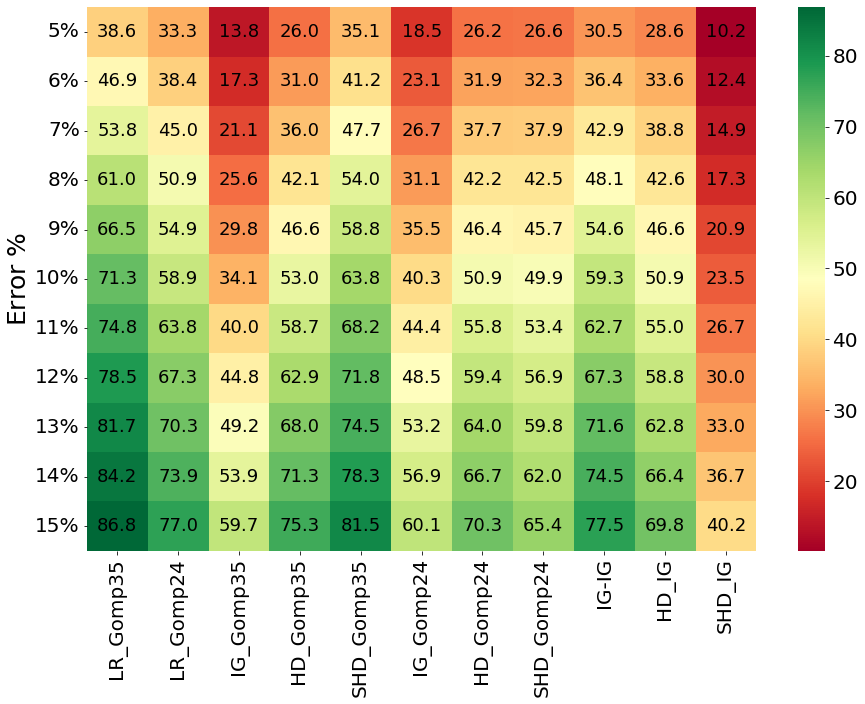

In [19]:
Model = ['LR_Gomp35','LR_Gomp24','IG_Gomp35','HD_Gomp35',
         'SHD_Gomp35','IG_Gomp24','HD_Gomp24','SHD_Gomp24','IG-IG','HD_IG','SHD_IG']

fig, ax = plt.subplots(figsize=(15, 10))
g = sns.heatmap(bwpercentage_df, annot_kws={'fontsize':18,'fontweight': 500,'c':'k'},
                annot = True,fmt=".1f", cmap="RdYlGn",cbar = True,xticklabels=Model)
ylabel = [str(i)+'%' for i in range(5,16,1)]
g.set_yticklabels(ylabel, rotation=0, horizontalalignment='right')

plt.ylabel('Error $\%$')
#plt.xlabel('Birthweight Prediction Models')
plt.savefig('FigOutput/heatmap.pdf', bbox_inches = 'tight', pad_inches = 0.05)
plt.show();


In [20]:
def calPercentagePlus(actual_bw, pred_bw, percent):
    percent_bwPlus, percent_bwMinus = [],[]
    for bw in actual_bw:
        percent_bwPlus.append(bw+((percent/100)*bw))
        percent_bwMinus.append(bw-((percent/100)*bw))
    count = 0
    
    for i in range(len(pred_bw)):
        if pred_bw[i]< percent_bwPlus[i] and pred_bw[i]> actual_bw[i]:
            count = count+1
    return np.round((count/len(actual_bw))*100,2)


In [21]:
bwpercentagePlus = list(zip(
                        [calPercentagePlus(actual_bw, bw_pred_lr_35week, i) for i in range(5,16,1)],
                        [calPercentagePlus(actual_bw, bw_pred_lr_24week, i) for i in range(5,16,1)],
                        [calPercentagePlus(actual_bw, bw_pred_ig_35week, i) for i in range(5,16,1)],
                        [calPercentagePlus(actual_bw, bw_pred_hd_35week, i) for i in range(5,16,1)],
                        [calPercentagePlus(actual_bw, bw_pred_shd_35week, i) for i in range(5,16,1)],
                        [calPercentagePlus(actual_bw, bw_pred_ig_24week, i) for i in range(5,16,1)],
                        [calPercentagePlus(actual_bw, bw_pred_hd_24week, i) for i in range(5,16,1)],
                        [calPercentagePlus(actual_bw, bw_pred_shd_24week, i) for i in range(5,16,1)],
                        [calPercentagePlus(actual_bw, bw_pred_ig_IG, i) for i in range(5,16,1)],
                        [calPercentagePlus(actual_bw, bw_pred_ig_HD, i) for i in range(5,16,1)],
                        [calPercentagePlus(actual_bw, bw_pred_ig_SHD, i) for i in range(5,16,1)]))

In [22]:
bwpercentagePlus_df = pd.DataFrame(bwpercentagePlus,
               columns = ['LR_Gomp35','LR_Gomp24','IG_Gomp35','HD_Gomp35',
         'SHD_Gomp35','IG_Gomp24','HD_Gomp24','SHD_Gomp24','IG-IG','HD_IG','SHD_IG'])

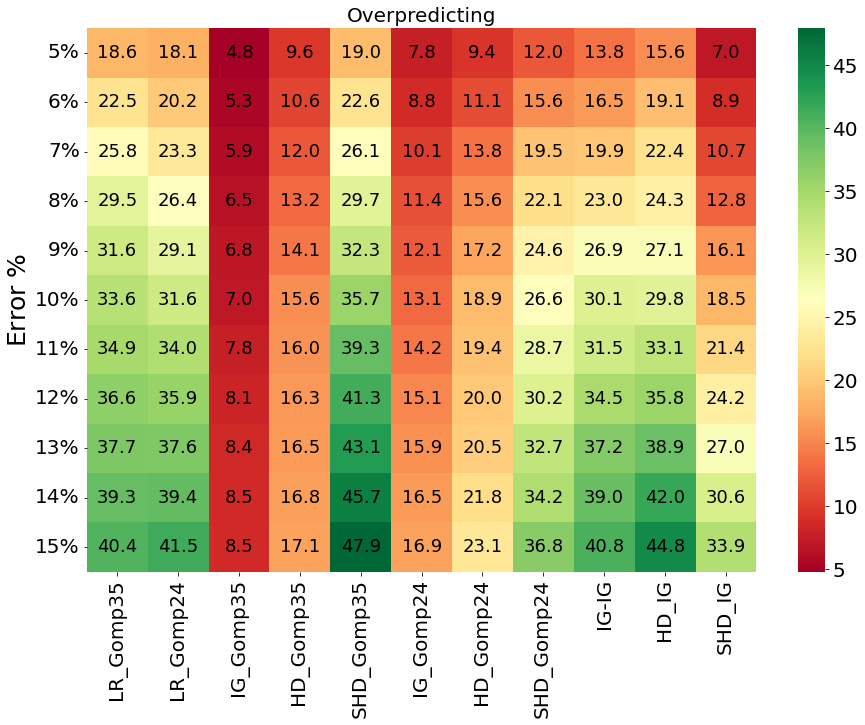

In [23]:
Model =  ['LR_Gomp35','LR_Gomp24','IG_Gomp35','HD_Gomp35',
         'SHD_Gomp35','IG_Gomp24','HD_Gomp24','SHD_Gomp24','IG-IG','HD_IG','SHD_IG']

fig, ax = plt.subplots(figsize=(15, 10))
g = sns.heatmap(bwpercentagePlus_df, annot_kws={'fontsize':18,'fontweight': 500,'c':'k'},
                annot = True,fmt=".1f", cmap="RdYlGn",cbar = True,xticklabels=Model)
ylabel = [str(i)+'%' for i in range(5,16,1)]
g.set_yticklabels(ylabel, rotation=0, horizontalalignment='right')

plt.ylabel('Error $\%$')
#plt.xlabel('Birthweight Prediction Models')
plt.title('Overpredicting')
plt.savefig('FigOutput/heatmapPlus.pdf', bbox_inches = 'tight', pad_inches = 0.05)
plt.show();


In [24]:
def calPercentageMinus(actual_bw, pred_bw, percent):
    percent_bwPlus, percent_bwMinus = [],[]
    for bw in actual_bw:
        percent_bwPlus.append(bw+((percent/100)*bw))
        percent_bwMinus.append(bw-((percent/100)*bw))
    count = 0
    
    for i in range(len(pred_bw)):
        if pred_bw[i]> percent_bwMinus[i] and pred_bw[i] < actual_bw[i]:
            count = count+1
    return np.round((count/len(actual_bw))*100,2)


In [25]:
bwpercentageMinus = list(zip(
                        [calPercentageMinus(actual_bw, bw_pred_lr_35week, i) for i in range(5,16,1)],
                        [calPercentageMinus(actual_bw, bw_pred_lr_24week, i) for i in range(5,16,1)],
                        [calPercentageMinus(actual_bw, bw_pred_ig_35week, i) for i in range(5,16,1)],
                        [calPercentageMinus(actual_bw, bw_pred_hd_35week, i) for i in range(5,16,1)],
                        [calPercentageMinus(actual_bw, bw_pred_shd_35week, i) for i in range(5,16,1)],
                        [calPercentageMinus(actual_bw, bw_pred_ig_24week, i) for i in range(5,16,1)],
                        [calPercentageMinus(actual_bw, bw_pred_hd_24week, i) for i in range(5,16,1)],
                        [calPercentageMinus(actual_bw, bw_pred_shd_24week, i) for i in range(5,16,1)],
                        [calPercentageMinus(actual_bw, bw_pred_ig_IG, i) for i in range(5,16,1)],
                        [calPercentageMinus(actual_bw, bw_pred_ig_HD, i) for i in range(5,16,1)],
                        [calPercentageMinus(actual_bw, bw_pred_ig_SHD, i) for i in range(5,16,1)]))

In [26]:
bwpercentageMinus_df = pd.DataFrame(bwpercentageMinus,
               columns = ['LR_Gomp35','LR_Gomp24','IG_Gomp35','HD_Gomp35',
         'SHD_Gomp35','IG_Gomp24','HD_Gomp24','SHD_Gomp24','IG-IG','HD_IG','SHD_IG'])

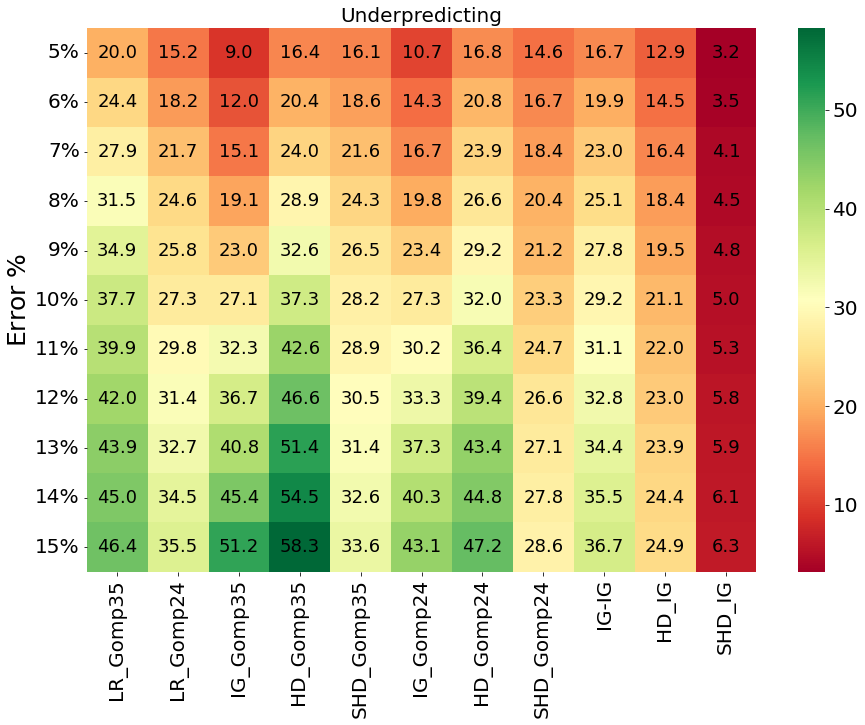

In [27]:
Model =  ['LR_Gomp35','LR_Gomp24','IG_Gomp35','HD_Gomp35',
         'SHD_Gomp35','IG_Gomp24','HD_Gomp24','SHD_Gomp24','IG-IG','HD_IG','SHD_IG']

fig, ax = plt.subplots(figsize=(15, 10))
g = sns.heatmap(bwpercentageMinus_df, annot_kws={'fontsize':18,'fontweight': 500,'c':'k'},
                annot = True,fmt=".1f", cmap="RdYlGn",cbar = True,xticklabels=Model)
ylabel = [str(i)+'%' for i in range(5,16,1)]
g.set_yticklabels(ylabel, rotation=0, horizontalalignment='right')

plt.ylabel('Error $\%$')
#plt.xlabel('Birthweight Prediction Models')
plt.title('Underpredicting')
plt.savefig('FigOutput/heatmapMinus.pdf', bbox_inches = 'tight', pad_inches = 0.05)
plt.show();


In [28]:
bw_pred_hd1_35week = Hadlock1birthWeightPred(X_pred_35week['AC35_atDel'],X_pred_35week['FL35_atDel'])

bw_pred_hd1_24week = Hadlock1birthWeightPred(X_pred_24week['AC24_atDel'],X_pred_24week['FL24_atDel'])



bw_pred_hd2_35week = Hadlock2birthWeightPred(X_pred_35week['AC35_atDel'],X_pred_35week['BPD35_atDel'],
                                             X_pred_35week['FL35_atDel'])

bw_pred_hd2_24week = Hadlock2birthWeightPred(X_pred_24week['AC24_atDel'], X_pred_24week['BPD24_atDel'],
                                             X_pred_24week['FL24_atDel'])




bw_pred_hd3_35week = Hadlock3birthWeightPred(X_pred_35week['HC35_atDel'],X_pred_35week['AC35_atDel'],
                                          X_pred_35week['FL35_atDel'])

bw_pred_hd3_24week = Hadlock3birthWeightPred(X_pred_24week['HC24_atDel'],X_pred_24week['AC24_atDel'],
                                          X_pred_24week['FL24_atDel'])



bw_pred_hd4_35week = Hadlock4birthWeightPred(X_pred_35week['HC35_atDel'],X_pred_35week['AC35_atDel'],
                                           X_pred_35week['BPD35_atDel'],X_pred_35week['FL35_atDel'])

bw_pred_hd4_24week = Hadlock4birthWeightPred(X_pred_24week['HC24_atDel'],X_pred_24week['AC24_atDel'],
                                           X_pred_24week['BPD24_atDel'],X_pred_24week['FL24_atDel'])


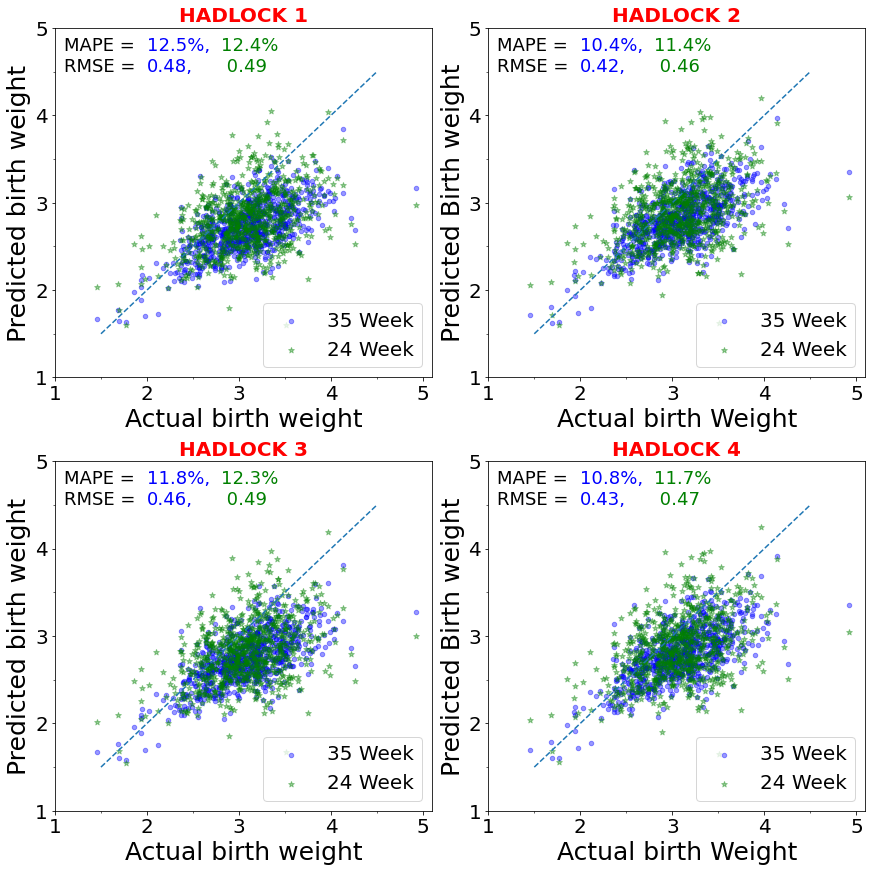

In [29]:
fig, ax = plt.subplots(2,2, figsize=(12, 12), constrained_layout=True)

plt.rcParams.update({
"xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'legend.fontsize': 20,
    'axes.labelsize': 25 ,
    
     'axes.titlesize': 20,
   
    'font.serif': 'DejaVu Serif'
    })

ax[0,0].scatter(actual_bw, bw_pred_hd1_35week,s=20,color='b',alpha = 0.4,label = '35 Week')
ax[0,0].scatter(actual_bw, bw_pred_hd1_24week,color='g',marker='*',alpha = 0.4,label = '24 Week')
ax[0,0].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[0,1].scatter(actual_bw, bw_pred_hd2_35week,s=20,color='b',alpha = 0.4,label = '35 Week')
ax[0,1].scatter(actual_bw, bw_pred_hd2_24week,color='g',marker='*',alpha = 0.4,label = '24 Week')
ax[0,1].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[1,0].scatter(actual_bw, bw_pred_hd3_35week,s=20,color='b',alpha = 0.4,label = '35 Week')
ax[1,0].scatter(actual_bw, bw_pred_hd3_24week,color='g',marker='*',alpha = 0.4,label = '24 Week')
ax[1,0].plot([1.5, 4.5], [1.5, 4.5],'--')

ax[1,1].scatter(actual_bw, bw_pred_hd4_35week,s=20,color='b',alpha = 0.4,label = '35 Week')
ax[1,1].scatter(actual_bw, bw_pred_hd4_24week,color='g',marker='*',alpha = 0.4,label = '24 Week')
ax[1,1].plot([1.5, 4.5], [1.5, 4.5],'--')


ax[0,0].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

ax[0,0].text(2,4.5,'{:0.1f}%,  \n{:0.2f},'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_hd1_35week)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_hd1_35week))),
             c = 'b',fontsize = 18)


ax[0,0].text(2.8,4.5, '{:0.1f}% \n {:0.2f}'.
            format(mean_absolute_percentage_error(actual_bw, bw_pred_hd1_24week)*100,
                   np.sqrt(mean_squared_error(actual_bw, bw_pred_hd1_24week))),c = 'g',
             fontsize = 18)

ax[0,1].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

ax[0,1].text(2,4.5,'{:0.1f}%,  \n{:0.2f},'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_hd2_35week)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_hd2_35week))),
             c = 'b',fontsize = 18)


ax[0,1].text(2.8,4.5, '{:0.1f}% \n {:0.2f}'.
            format(mean_absolute_percentage_error(actual_bw, bw_pred_hd2_24week)*100,
                   np.sqrt(mean_squared_error(actual_bw, bw_pred_hd2_24week))),c = 'g',
             fontsize = 18)


ax[1,0].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

ax[1,0].text(2,4.5,'{:0.1f}%,  \n{:0.2f},'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_hd3_35week)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_hd3_35week))),
             c = 'b',fontsize = 18)


ax[1,0].text(2.8,4.5, '{:0.1f}% \n {:0.2f}'.
            format(mean_absolute_percentage_error(actual_bw, bw_pred_hd3_24week)*100,
                   np.sqrt(mean_squared_error(actual_bw, bw_pred_hd3_24week))),c = 'g',
             fontsize = 18)


ax[1,1].text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

ax[1,1].text(2,4.5,'{:0.1f}%,  \n{:0.2f},'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_hd4_35week)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_hd4_35week))),
             c = 'b',fontsize = 18)


ax[1,1].text(2.8,4.5, '{:0.1f}% \n {:0.2f}'.
            format(mean_absolute_percentage_error(actual_bw, bw_pred_hd4_24week)*100,
                   np.sqrt(mean_squared_error(actual_bw, bw_pred_hd4_24week))),c = 'g',
             fontsize = 18)



ax[0,0].set_xticks(np.arange(1, 6, 1))
ax[0,0].set_yticks(np.arange(1, 6, 1))

ax[0,1].set_xticks(np.arange(1, 6, 1))
ax[0,1].set_yticks(np.arange(1, 6, 1))

ax[1,0].set_xticks(np.arange(1, 6, 1))
ax[1,0].set_yticks(np.arange(1, 6, 1))

ax[1,1].set_xticks(np.arange(1, 6, 1))
ax[1,1].set_yticks(np.arange(1, 6, 1))

ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[0,0].set_xlabel('Actual birth weight')
ax[0,0].set_ylabel('Predicted birth weight')

ax[0,1].set_ylabel('Predicted Birth weight')
ax[0,1].set_xlabel('Actual birth Weight')

ax[1,0].set_xlabel('Actual birth weight')
ax[1,0].set_ylabel('Predicted birth weight')

ax[1,1].set_ylabel('Predicted Birth weight')
ax[1,1].set_xlabel('Actual birth Weight')


ax[0,0].set_title('HADLOCK 1',color = 'r',weight='bold')
ax[0,1].set_title('HADLOCK 2',color = 'r',weight='bold')
ax[1,0].set_title('HADLOCK 3',color = 'r',weight='bold')
ax[1,1].set_title('HADLOCK 4',color = 'r',weight='bold')

ax[0,0].legend(loc = 'lower right', frameon = True);
ax[0,1].legend(loc = 'lower right', frameon = True);
ax[1,0].legend(loc = 'lower right', frameon = True);
ax[1,1].legend(loc = 'lower right', frameon = True);

plt.savefig('FigOutput/Hadlock.png',dpi = 600,bbox_inches='tight')
plt.savefig('FigOutput/Hadlock.pdf',dpi = 600,bbox_inches='tight')

In [30]:
df_obj_withMaternal = pd.read_pickle(r'BWPredictionWithMaternal_LASSO.pickle')

actual_bw = [df_obj_withMaternal['BWActual'][i][0] for i in range(len(df_obj_withMaternal))]
bw_pred_lasso_35withMaternal = [df_obj_withMaternal['BWPredicted35'][i][0] 
                                for i in range(len(df_obj_withMaternal))]
bw_pred_lasso_24withMaternal = [df_obj_withMaternal['BWPredicted24'][i][0] 
                                for i in range(len(df_obj_withMaternal))]

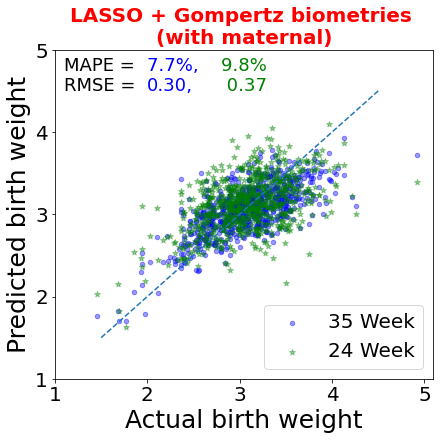

In [31]:
fig, ax = plt.subplots(1,1, figsize=(6, 6), constrained_layout=True)

plt.rcParams.update({
"xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'legend.fontsize': 20,
    'axes.labelsize': 25 ,
    
     'axes.titlesize': 20,
   
    'font.serif': 'DejaVu Serif'
    })


plt.scatter(actual_bw, bw_pred_lasso_35withMaternal,s=20,color='b',alpha = 0.4,label = '35 Week')
plt.scatter(actual_bw, bw_pred_lasso_24withMaternal,color='g',marker='*',alpha = 0.4,label = '24 Week')
plt.plot([1.5, 4.5], [1.5, 4.5],'--')


plt.text(1.1,4.5,'MAPE = \nRMSE = ',c = 'k',fontsize = 18)

plt.text(2,4.5,'{:0.1f}%,  \n{:0.2f},'.
             format(mean_absolute_percentage_error(actual_bw, bw_pred_lasso_35withMaternal)*100,
                    np.sqrt(mean_squared_error(actual_bw, bw_pred_lasso_35withMaternal))),
             c = 'b',fontsize = 18)

plt.text(2.8,4.5, '{:0.1f}% \n {:0.2f}'.
            format(mean_absolute_percentage_error(actual_bw, bw_pred_lasso_24withMaternal)*100,
                   np.sqrt(mean_squared_error(actual_bw, bw_pred_lasso_24withMaternal))),c = 'g',
             fontsize = 18)




plt.xticks(np.arange(1, 6, 1))
plt.yticks(np.arange(1, 6, 1))


#plt.xaxis.set_minor_locator(MultipleLocator(0.5))
#plt.yaxis.set_minor_locator(MultipleLocator(0.5))


plt.xlabel('Actual birth weight')
plt.ylabel('Predicted birth weight')

plt.title('LASSO + Gompertz biometries \n(with maternal)',color = 'r',weight='bold')

plt.legend(loc = 'lower right', frameon = True);

plt.savefig('FigOutput/BWPridiction_plot_maternal.png',dpi = 600,bbox_inches='tight')
plt.savefig('FigOutput/BWPridiction_plot_maternal.pdf',dpi = 600,bbox_inches='tight')